# KAGGLE - TITANIC

This notebook tackles the Titanic Kaggle.

----

<a id='Summary'></a>

[0. Data & packages](#section0)

[1. Useful functions](#section1)

[2. Pre-processing](#section2)

[3. EDA & FE](#section3)

[4. Modeling & Evaluation](#section4)

----

<a id='section0'></a>
# 0. Data & packages
<a href='#Summary'>Haut de page</a>

In [537]:
import warnings

import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, make_scorer

import xgboost as xgb

import shap
import pickle


In [595]:
RANDOM_STATE = 42

In [596]:
X_train = pd.read_csv('./DATA/train.csv')
X_test = pd.read_csv('./DATA/test.csv')

<a id='section1'></a>
# 1. Useful functions
<a href='#Summary'>Haut de page</a>

In [597]:
# Useful functions
def feature_names(sklearn_feature_name_output, df):
    """
    This function takes the output from the .get_feature_names() method on the PolynomialFeatures 
    instance and replaces values with df column names to return output such as 'Col_1 x Col_2'

    sklearn_feature_name_output: The list object returned when calling .get_feature_names() on the PolynomialFeatures object
    df: Pandas dataframe with correct column names
    """
    cols = df.columns.tolist()
    feat_map = {'x'+str(num):cat for num, cat in enumerate(cols)}
    feat_string = ','.join(sklearn_feature_name_output)
    for k,v in feat_map.items():
        feat_string = re.sub(fr"\b{k}\b",v,feat_string)
    return feat_string.replace(" "," x ").split(',')

def compute_score(clf, X, y):
    """
    This function evaluates clf on data by taking the mean of 5-fold CV
    """

    cval = cross_val_score(clf, X, y, cv = 5)

    return np.mean(cval)

def count_plot(df, x, y, index_list=None):
    """
    This function renders a count plot graph of variables in cols with y as hue
    """

    plt.figure(figsize=(7,5), dpi=100)
    sns.countplot(data=df, x=x, hue=y)
    plt.title(f"{x}")

    if not index_list:
         index_list = [z for w in [(x-0.2, x+0.2) for x in list(range(df[x].dropna().nunique()))] for z in w]

    # Number
    hist_dict = dict(df.groupby(x)[y].value_counts())
    hist_list = [(w,z) for w in df[x].dropna().unique() for z in df[y].dropna().unique()]
    y_max = max(hist_dict.values())

    # %
    hist_dict_per = dict(df.groupby(x)[y].count())
    
    for index, value in enumerate(hist_list):
        plt.text(index_list[index], 
                hist_dict[value]+3*y_max/50, 
                str(hist_dict[value]), 
                ha='center', 
                weight='bold')
        plt.text(index_list[index], 
                hist_dict[value]+y_max/50, 
                str(round(hist_dict[value]*100/hist_dict_per[value[0]],1))+'%', 
                ha='center')
    
    plt.tight_layout()

<a id='section2'></a>
# 2. Pre-processing
<a href='#Summary'>Haut de page</a>

In [598]:
X_train.shape, X_test.shape

((891, 12), (418, 11))

In [599]:
X_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [600]:
df_null_train = pd.DataFrame(X_train.isnull().sum(), columns=['number']).join(pd.DataFrame(np.round(X_train.isnull().mean()*100), columns=['%']))
df_null_train = df_null_train[df_null_train["number"] != 0]
df_null_train

,number,%
Age,177,20.0
Cabin,687,77.0
Embarked,2,0.0


In [601]:
df_null_test = pd.DataFrame(X_test.isnull().sum(), columns=['number']).join(pd.DataFrame(np.round(X_test.isnull().mean()*100), columns=['%']))
df_null_test = df_null_test[df_null_test["number"] != 0]
df_null_test

,number,%
Age,86,21.0
Fare,1,0.0
Cabin,327,78.0


In [602]:
X_train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [603]:
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [604]:
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [605]:
df = pd.concat([X_train.drop(['Survived'], axis=1), X_test]).reset_index(drop=True)

In [606]:
df.shape

(1309, 11)

<a id='section3'></a>
# 3. EDA & FE
<a href='#Summary'>Haut de page</a>

In [77]:
df.select_dtypes(include='object').dtypes

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

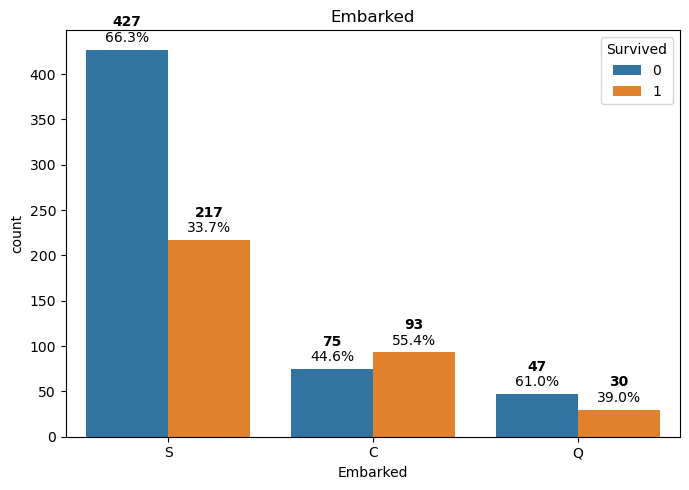

In [15]:
x = 'Embarked'
y = 'Survived'
count_plot(X_train, x, y)

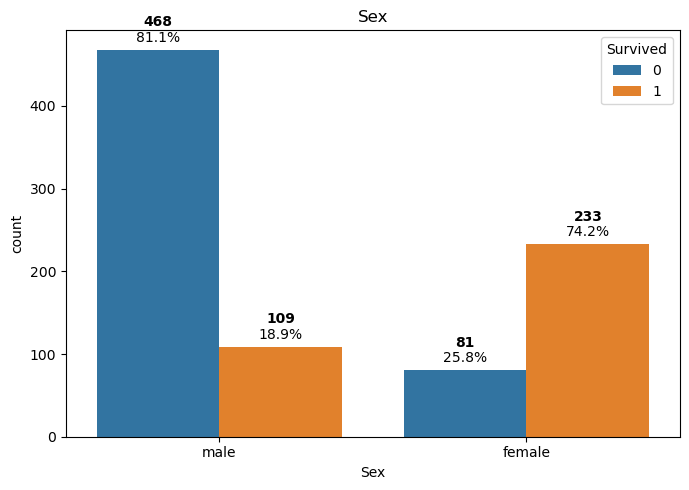

In [16]:
x = 'Sex'
y = 'Survived'
count_plot(X_train, x, y)

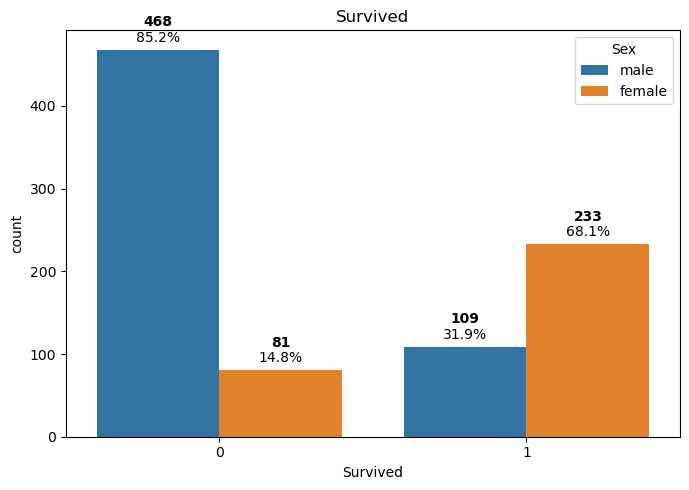

In [17]:
x = 'Survived'
y = 'Sex'
count_plot(X_train, x, y)

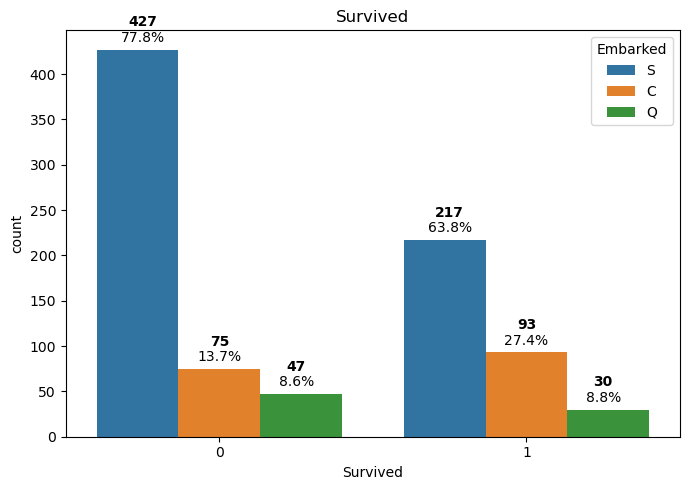

In [18]:
x = 'Survived'
y = 'Embarked'
count_plot(X_train, x, y, index_list = [-0.25, 0, 0.25, 0.75, 1, 1.25])

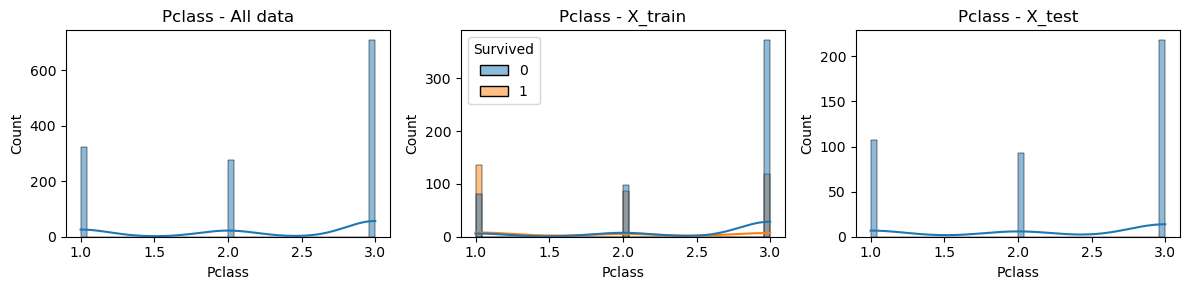

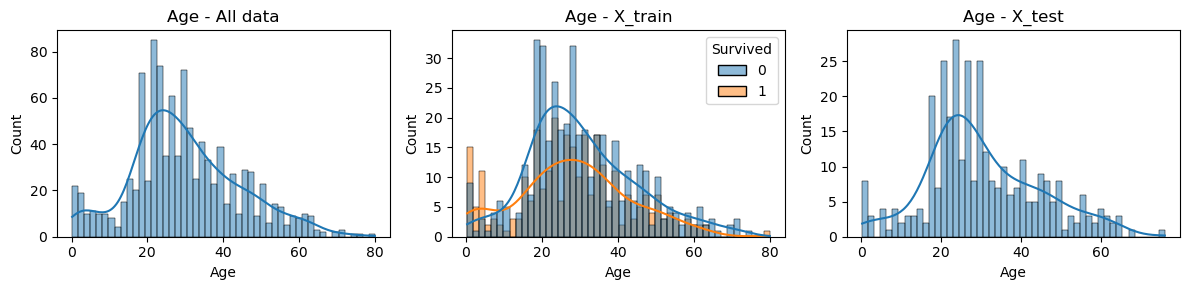

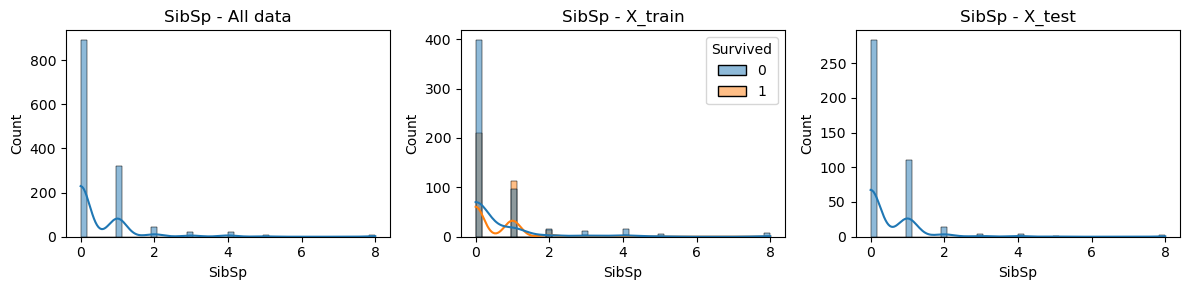

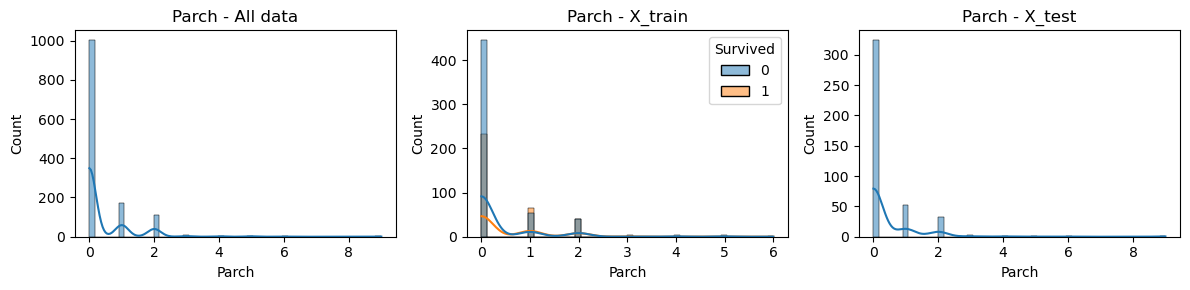

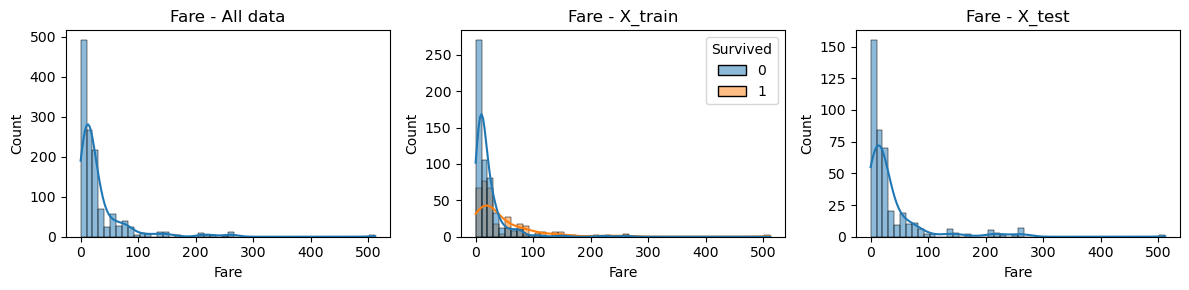

In [19]:
cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

for x in cols:
    fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3), dpi=100)
    
    sns.histplot(ax=axes[0], data=df, x=x, bins=50, kde=True)
    axes[0].set_title(f"{x} - All data")

    sns.histplot(ax=axes[1], data=X_train, x=x, bins=50, kde=True, hue = 'Survived')
    axes[1].set_title(f"{x} - X_train")
    
    sns.histplot(ax=axes[2], data=X_test, x=x, bins=50, kde=True)
    axes[2].set_title(f"{x} - X_test")
    
    plt.tight_layout()

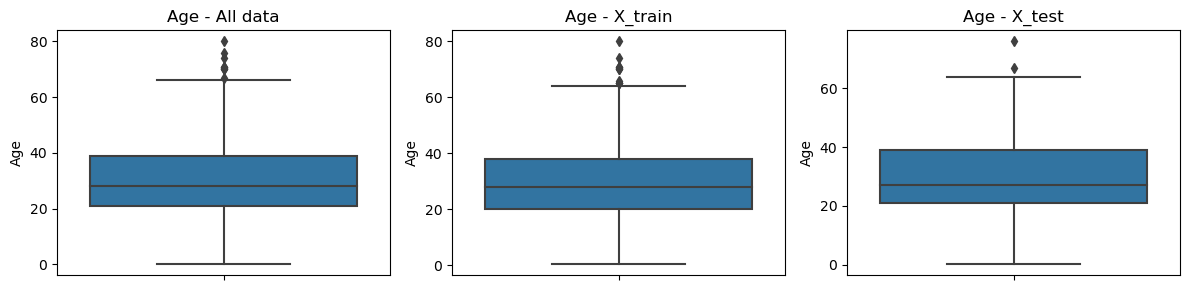

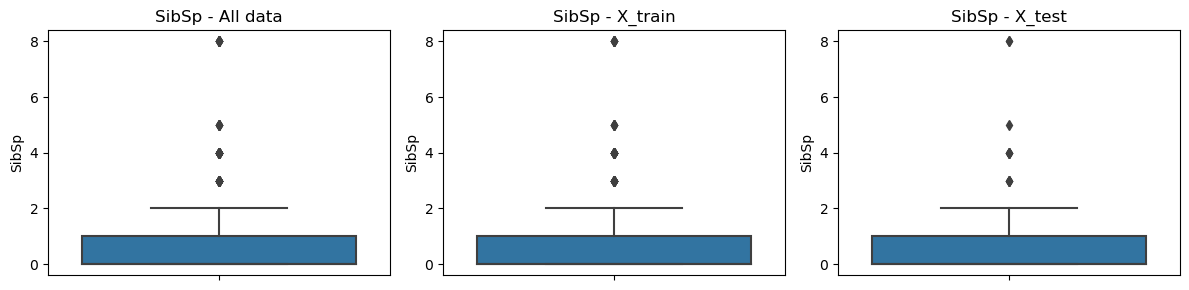

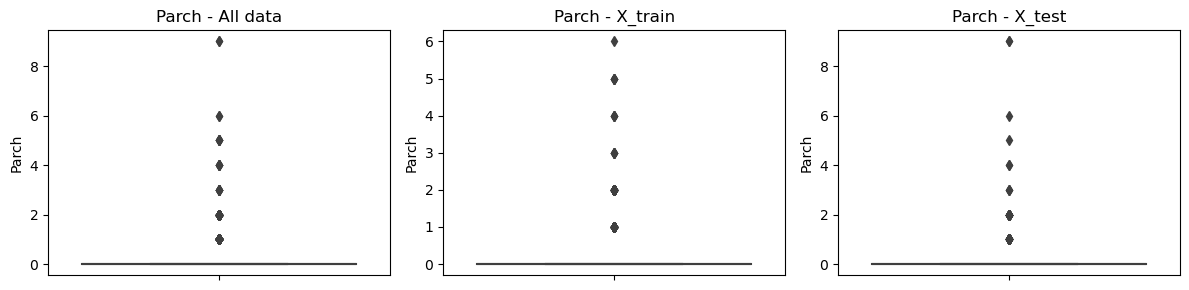

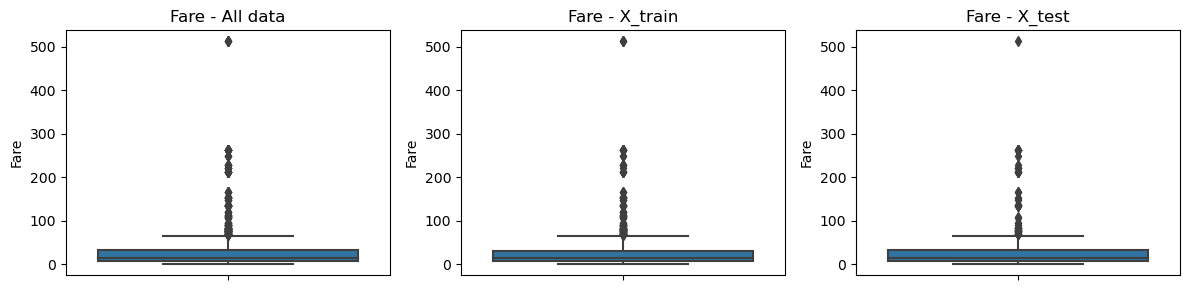

In [436]:
cols = ['Age', 'SibSp', 'Parch', 'Fare']

for x in cols:
    fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3), dpi=100)
    sns.boxplot(ax=axes[0], data=df, y=x)
    axes[0].set_title(f"{x} - All data")

    sns.boxplot(ax=axes[1], data=X_train, y=x)
    axes[1].set_title(f"{x} - X_train")

    sns.boxplot(ax=axes[2], data=X_test, y=x)
    axes[2].set_title(f"{x} - X_test")
    
    plt.tight_layout()

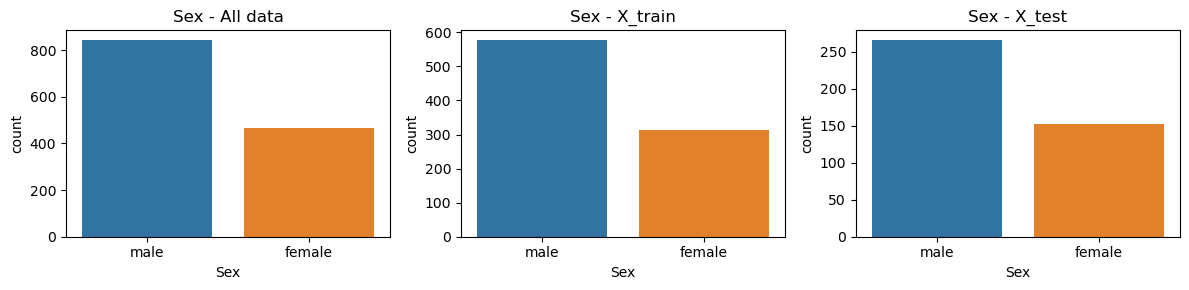

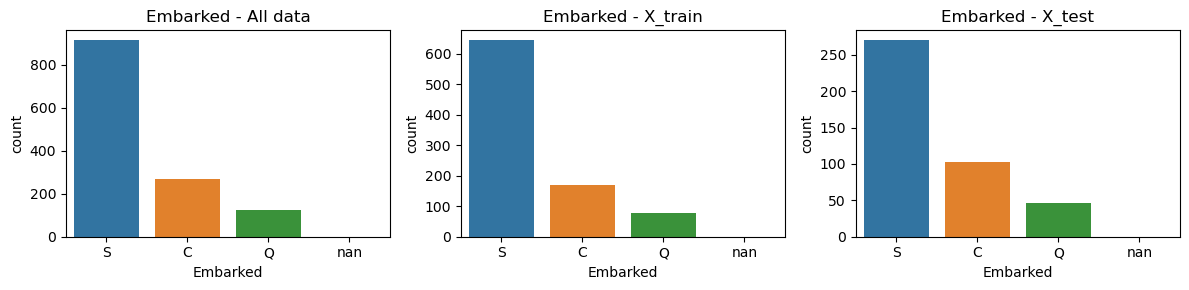

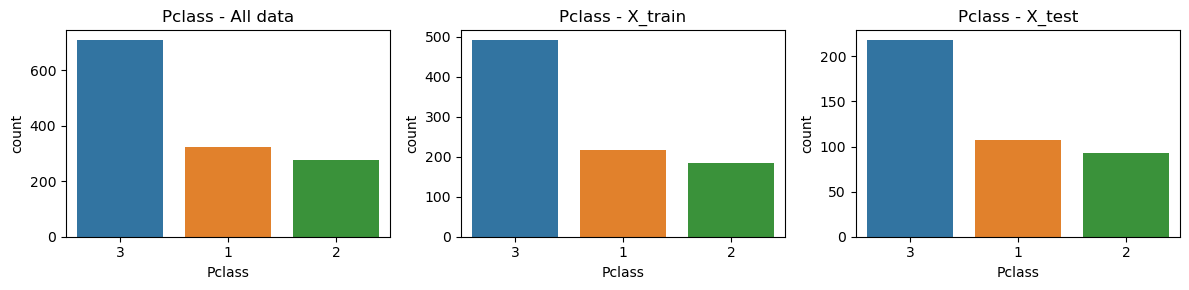

In [437]:
cols = ['Sex', 'Embarked', 'Pclass']

for x in cols:
    fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3), dpi=100)
    sns.countplot(ax=axes[0], data=df, x=x, order = df[x].unique().tolist())
    axes[0].set_title(f"{x} - All data")

    sns.countplot(ax=axes[1], data=X_train, x=x, order = df[x].unique().tolist())
    axes[1].set_title(f"{x} - X_train")

    sns.countplot(ax=axes[2], data=X_test, x=x, order = df[x].unique().tolist())
    axes[2].set_title(f"{x} - X_test")
    
    plt.tight_layout()

Text(0.5, 1.0, 'Correlation')

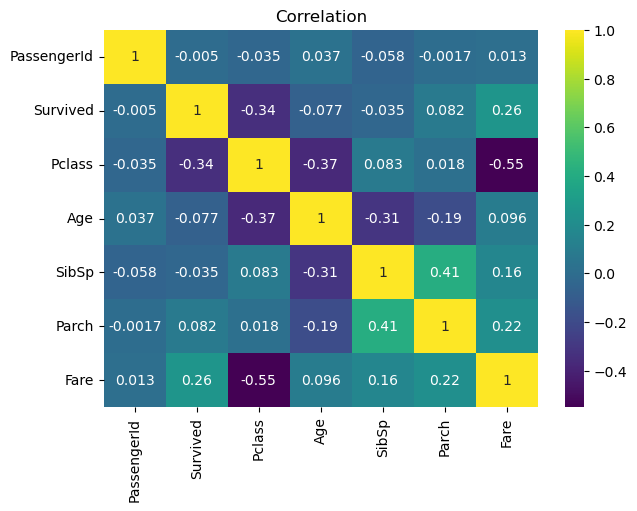

In [70]:
df_corr = X_train.corr()
plt.figure(figsize=(7,5), dpi=100)
sns.heatmap(data=df_corr, annot=True, cmap='viridis')
plt.title("Correlation")

<Figure size 1000x800 with 0 Axes>

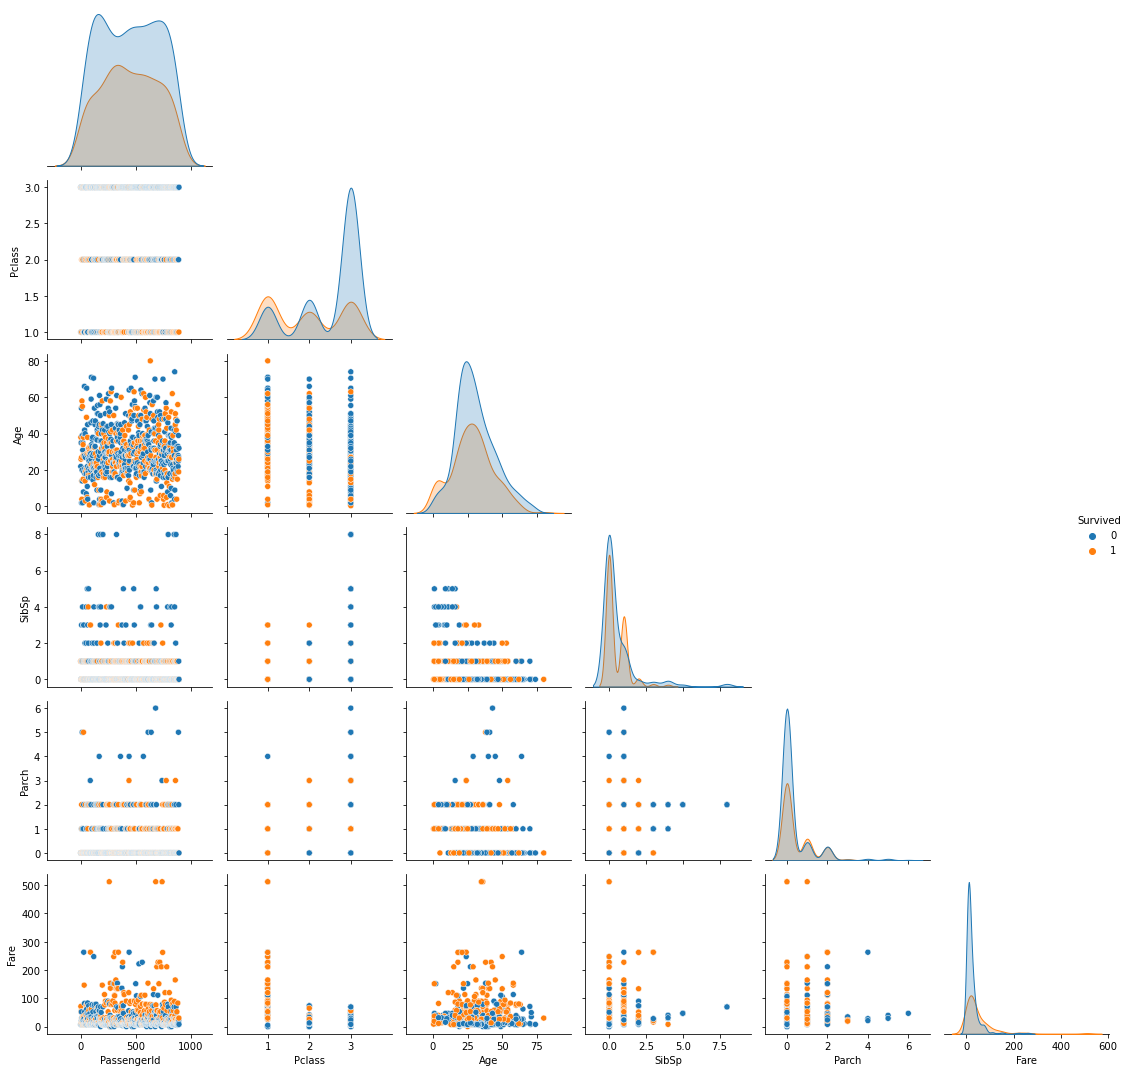

In [71]:
plt.figure(figsize=(10,8), dpi=100)
sns.pairplot(data = X_train, hue = "Survived", corner=True)
plt.tight_layout()

In [607]:
df.shape, X_train.shape, X_test.shape

((1309, 11), (891, 12), (418, 11))

In [608]:
# Outliers
# df = df[(df.Fare <= 300) & ((df.Age <= 75) | df.Age.isnull())]

In [609]:
df.shape, X_train.shape, X_test.shape

((1309, 11), (891, 12), (418, 11))

In [610]:
def fe_na(df):
    
    # NAs mask
    df['age_na'] = df['Age'].isnull().astype('category')
    df['embarked_na'] = df['Embarked'].isnull().astype('category')
    df['cabin_na'] = df['Cabin'].isnull().astype('category')

    return df

In [611]:
df = fe_na(df)
X_train = fe_na(X_train)
X_test = fe_na(X_test)

In [612]:
df_null_train

,number,%
Age,177,20.0
Cabin,687,77.0
Embarked,2,0.0


In [613]:
df_null_test

,number,%
Age,86,21.0
Fare,1,0.0
Cabin,327,78.0


In [614]:
# Features

def fe(df):
    
    # Cabin first letter
    df['deck'] = df['Cabin'].apply(lambda x : str(x)[0])

    # Cabin last two letters
    df['room'] = df['Cabin'].str.slice(1).str.extract("([0-9]+)", expand=False).astype('float')

    # Passengers in the deck
    df['deck_passengers'] = df.groupby('deck')['deck'].transform('count')

    # Ticket groupe
    df['Ticket'] = df['Ticket'].str.replace('.', '')
    df['Ticket'] = df['Ticket'].str.replace('/', '')
    df['ticket_prefix'] = df['Ticket'].str.split()
    # df['ticket_prefix'] = df['ticket_prefix'].str.strip()
    df['ticket_prefix'] = df['ticket_prefix'].apply(lambda x : x[0] if len(x) > 1 else 'XXX')
    # df['ticket_prefix'] = df['Ticket'].apply(lambda x : str(x)[:3] if str(x)[0].isdigit() else str(x)[:4].lower())

    # Group members for each passenger
    df['group_members'] = df.groupby('Ticket')['Ticket'].transform('count')

    # Family members
    df['family_members'] = df['SibSp']+df['Parch']+1

    # # Parch - cat
    # df.loc[df['Parch'] > 2, 'Parch'] = 3
    
    # # SibSp - cat
    # df.loc[df['SibSp'] > 3, 'SibSp'] = 4

    # family_size
    df.loc[df['family_members'] == 1, 'family_size'] = "alone_family"
    df.loc[(df['family_members'] >= 2) & (df['family_members'] < 5), 'family_size'] = "small_family"
    df.loc[(df['family_members'] >= 5), 'family_size'] = "large_family"

    # group_size
    df.loc[df['group_members'] == 1, 'group_size'] = "alone_group"
    df.loc[(df['group_members'] >= 2) & (df['group_members'] < 5), 'group_size'] = "small_group"
    df.loc[(df['group_members'] >= 5), 'group_size'] = "large_group"

    # Title
    df['title'] = df['Name'].apply(lambda x : x.split(', ')[-1].split('.')[0])

    df.loc[df['title'] == 'Mlle', 'title'] = 'Miss'
    
    df.loc[df['title'] == 'Ms', 'title'] = 'Mrs'
    df.loc[df['title'] == 'Mme', 'title'] = 'Mrs'

    df.loc[df['title'] == 'Lady', 'title'] = 'Noble'
    df.loc[df['title'] == 'the Countess', 'title'] = 'Noble'
    df.loc[df['title'] == 'Dona', 'title'] = 'Noble'
    df.loc[df['title'] == 'Sir', 'title'] = 'Noble'
    df.loc[df['title'] == 'Don', 'title'] = 'Noble'
    df.loc[df['title'] == 'Jonkheer', 'title'] = 'Noble'

    df.loc[df['title'] == 'Capt', 'title'] = 'Officer'
    df.loc[df['title'] == 'Major', 'title'] = 'Officer'
    df.loc[df['title'] == 'Col', 'title'] = 'Officer'
    df.loc[df['title'] == 'Dr', 'title'] = 'Officer'
    df.loc[df['title'] == 'Rev', 'title'] = 'Officer'

    # Nickname
    df['nickname'] = df['Name'].apply(lambda x : '(' in x).astype('category')

    # # Age_group
    # # df['child'] = df['Age'].apply(lambda x : 1 if x <=8 else 0).astype('category')
    # df.loc[df['Age'] < 10, 'age_group'] = 0
    # df.loc[(df['Age'] >= 10) & (df['Age'] < 20), 'age_group'] = 1
    # df.loc[(df['Age'] >= 20) & (df['Age'] < 50), 'age_group'] = 2
    # df.loc[(df['Age'] >= 50), 'age_group'] = 3

    return df

In [615]:
df = fe(df)
X_train = fe(X_train)
X_test = fe(X_test)

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [616]:
# Using train set category median age to impute missing values
df_imputation = pd.DataFrame(X_train.groupby(['Sex', 'Pclass', 'title'])['Age'].median()).reset_index()
df_imputation

,Sex,Pclass,title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Noble,40.5
3,female,1,Officer,49.0
4,female,2,Miss,24.0
5,female,2,Mrs,31.5
6,female,3,Miss,18.0
7,female,3,Mrs,31.0
8,male,1,Master,4.0
9,male,1,Mr,40.0


In [617]:
# Imputation - cat

# df[df["Embarked"].isnull()]
# df[df["Pclass"] == 1].groupby("Embarked")["Fare"].agg(['count', 'mean', 'median'])
X_train['Embarked'] = X_train['Embarked'].fillna('C')

In [618]:
# Imputation - Num - Age

def imputation_age(row):
    condition = ((df_imputation["Sex"] == row["Sex"]) &
                (df_imputation["Pclass"] == row["Pclass"]) & 
                (df_imputation["title"] == row["title"]))
    
    res = df_imputation[condition]["Age"].values[0]

    return res

X_train["Age"] = X_train.apply(lambda x : imputation_age(x) if np.isnan(x["Age"]) else x["Age"], axis=1)
X_test["Age"] = X_test.apply(lambda x : imputation_age(x) if np.isnan(x["Age"]) else x["Age"], axis=1)

In [619]:
# Imputation - Num - Fare

# strat_nan_num='mean'
strat_nan_num='median'

imp_cols = ['Fare']

quant_transformer = Pipeline(
    steps=[('Imputer', SimpleImputer(strategy = strat_nan_num))]) 

preprocessor_imp = ColumnTransformer(
    transformers=[('quant', quant_transformer, imp_cols),],
    remainder='passthrough', verbose_feature_names_out=False)

preprocessor_imp.fit(df[imp_cols])

X_train[imp_cols] = preprocessor_imp.transform(X_train[imp_cols])
X_test[imp_cols] = preprocessor_imp.transform(X_test[imp_cols])

In [620]:
cat_cols = ['Sex'
            , 'Embarked'
            , 'Pclass'
            
            # , 'age_na' 
            # , 'embarked_na'
            # , 'cabin_na'

            , 'deck' 
            , 'family_size'
            , 'group_size'
            , 'title' 
            , 'ticket_prefix'

            # , 'nickname' 
            # , 'child' 
            # , 'SibSp'
            # , 'Parch'
            ]

num_cols = ['Fare'
            , 'Age'
            # , 'age_group' 
            # , 'group_members' 
            # , 'family_members'
            # , 'deck_passengers'
            # , "room"
            ]
features = cat_cols + num_cols
target = 'Survived'

In [621]:
y_train = X_train[target]
X_train = X_train[features]

y_pred_id = X_test['PassengerId']
X_test = X_test[features]

In [622]:
X_train.shape, y_train.shape

((891, 10), (891,))

In [623]:
X_train.head().T

,0,1,2,3,4
Sex,male,female,female,female,male
Embarked,S,C,S,S,S
Pclass,3,1,3,1,3
deck,n,C,n,C,n
family_size,small_family,small_family,alone_family,small_family,alone_family
group_size,alone_group,alone_group,alone_group,small_group,alone_group
title,Mr,Mrs,Miss,Mrs,Mr
ticket_prefix,A5,PC,STONO2,XXX,XXX
Fare,7.25,71.2833,7.925,53.1,8.05
Age,22.0,38.0,26.0,35.0,35.0


In [624]:
X_train_index = X_train.index
X_test_index = X_test.index

# OH encoding
categorical_transformer = Pipeline(
    steps=[('OHencoder', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
    ])

preprocessor_oh = ColumnTransformer(
    transformers=[('cat', categorical_transformer, cat_cols)],
    remainder='passthrough', 
    verbose_feature_names_out=False)

X_oh_train = pd.DataFrame(preprocessor_oh.fit_transform(X_train), columns = preprocessor_oh.get_feature_names_out())
X_train = X_oh_train.set_index(X_train_index)

X_oh_test = pd.DataFrame(preprocessor_oh.transform(X_test), columns = preprocessor_oh.get_feature_names_out())
X_test = X_oh_test.set_index(X_test_index)


Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros


In [625]:
X_train.shape, X_test.shape

((891, 53), (418, 53))

In [626]:
np.sort(X_train.columns)

array(['Age', 'Embarked_Q', 'Embarked_S', 'Fare', 'Pclass_2', 'Pclass_3',
       'Sex_male', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F',
       'deck_G', 'deck_T', 'deck_n', 'family_size_large_family',
       'family_size_small_family', 'group_size_large_group',
       'group_size_small_group', 'ticket_prefix_A5', 'ticket_prefix_AS',
       'ticket_prefix_C', 'ticket_prefix_CA', 'ticket_prefix_CASOTON',
       'ticket_prefix_FC', 'ticket_prefix_FCC', 'ticket_prefix_Fa',
       'ticket_prefix_PC', 'ticket_prefix_PP', 'ticket_prefix_PPP',
       'ticket_prefix_SC', 'ticket_prefix_SCA4', 'ticket_prefix_SCAH',
       'ticket_prefix_SCOW', 'ticket_prefix_SCPARIS',
       'ticket_prefix_SCParis', 'ticket_prefix_SOC', 'ticket_prefix_SOP',
       'ticket_prefix_SOPP', 'ticket_prefix_SOTONO2',
       'ticket_prefix_SOTONOQ', 'ticket_prefix_SP', 'ticket_prefix_STONO',
       'ticket_prefix_STONO2', 'ticket_prefix_SWPP', 'ticket_prefix_WC',
       'ticket_prefix_WEP', 'ticket_prefix_XXX', '

In [627]:
np.sort(X_train.columns)

array(['Age', 'Embarked_Q', 'Embarked_S', 'Fare', 'Pclass_2', 'Pclass_3',
       'Sex_male', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F',
       'deck_G', 'deck_T', 'deck_n', 'family_size_large_family',
       'family_size_small_family', 'group_size_large_group',
       'group_size_small_group', 'ticket_prefix_A5', 'ticket_prefix_AS',
       'ticket_prefix_C', 'ticket_prefix_CA', 'ticket_prefix_CASOTON',
       'ticket_prefix_FC', 'ticket_prefix_FCC', 'ticket_prefix_Fa',
       'ticket_prefix_PC', 'ticket_prefix_PP', 'ticket_prefix_PPP',
       'ticket_prefix_SC', 'ticket_prefix_SCA4', 'ticket_prefix_SCAH',
       'ticket_prefix_SCOW', 'ticket_prefix_SCPARIS',
       'ticket_prefix_SCParis', 'ticket_prefix_SOC', 'ticket_prefix_SOP',
       'ticket_prefix_SOPP', 'ticket_prefix_SOTONO2',
       'ticket_prefix_SOTONOQ', 'ticket_prefix_SP', 'ticket_prefix_STONO',
       'ticket_prefix_STONO2', 'ticket_prefix_SWPP', 'ticket_prefix_WC',
       'ticket_prefix_WEP', 'ticket_prefix_XXX', '

In [628]:
X_train.shape, X_test.shape

((891, 53), (418, 53))

In [629]:
# Scaling
scaler = StandardScaler()

scaler.fit(X_train[num_cols])

X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [630]:
# PCA
# Elbow method

# explained_variance = []
# range_pc = range(1,8)

# for k in range_pc:
#     # print(f"Fitting PCA for {k} principal components")
#     pca = PCA(n_components=k)
#     pca.fit(X[num_cols])
#     explained_variance.append(np.sum(pca.explained_variance_ratio_))

# plt.figure(figsize=(10,3), dpi=100)
# plt.plot(range_pc, explained_variance, marker='o', markerfacecolor='red', markeredgecolor='black')
# plt.tight_layout()

In [631]:
# # PCA 
# cat_cols_oh = [col for col in X.columns if col not in num_cols]

# pca = PCA(n_components=5)

# X_num_pca = pd.DataFrame(pca.fit_transform(X[num_cols]), columns = feature_names(pca.get_feature_names_out(), X[num_cols]))

# X = pd.concat([X[cat_cols_oh].reset_index(drop=True), X_num_pca.reset_index(drop=True)], axis=1)

# X = X.set_index(y.index)

In [632]:
# # Polynomial features
# cat_cols_oh = [col for col in X.columns if col not in num_cols]

# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# X_num_poly = pd.DataFrame(poly.fit_transform(X[num_cols]), 
#                           columns = feature_names(poly.get_feature_names_out(), X[num_cols]))

# X = pd.concat([X[cat_cols_oh].reset_index(drop=True), X_num_poly.reset_index(drop=True)], axis=1)

# X = X.set_index(y.index)

In [633]:
# # Feature selection
# estimator = LogisticRegression(penalty = 'l2',
#                          C = 1,
#                          solver='sag', 
#                          random_state=RANDOM_STATE, max_iter=10000)

# selector = RFE(estimator, n_features_to_select=10, step=1)
# selector = selector.fit(X, y)

In [634]:
# selector.get_feature_names_out()

In [635]:
# Data type
# cat_cols_new = [col for col in X.columns if col not in num_cols]
# X_oh[cat_cols_new] = X_oh[cat_cols_new].astype('float')
# X[cat_cols_new] = X[cat_cols_new].astype(bool)

In [636]:
X_train.shape, X_test.shape

((891, 53), (418, 53))

In [637]:
X_train.head().T

,0,1,2,3,4
Sex_male,1.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,0.000000,0.000000,0.000000,0.000000,0.000000
Embarked_S,1.000000,0.000000,1.000000,1.000000,1.000000
Pclass_2,0.000000,0.000000,0.000000,0.000000,0.000000
Pclass_3,1.000000,0.000000,1.000000,0.000000,1.000000
deck_B,0.000000,0.000000,0.000000,0.000000,0.000000
deck_C,0.000000,1.000000,0.000000,1.000000,0.000000
deck_D,0.000000,0.000000,0.000000,0.000000,0.000000
deck_E,0.000000,0.000000,0.000000,0.000000,0.000000
deck_F,0.000000,0.000000,0.000000,0.000000,0.000000


<a id='section4'></a>
# 4. Modeling & evaluation
<a href='#Summary'>Haut de page</a>

In [638]:
X_train.to_pickle('./DATA/X.pkl')
y_train.to_pickle("./DATA/y.pkl")

Logistic regression

In [639]:
clf = LogisticRegression(penalty = 'l2',
                         C = 1,
                         solver='sag', 
                         random_state=RANDOM_STATE, max_iter=10000)

compute_score(clf, X_train, y_train)

0.8305316678174629

SVM

In [640]:
clf = SVC(C = 1, kernel = 'poly', degree = 3, gamma = 'scale', class_weight = 'balanced',
          random_state=RANDOM_STATE, max_iter=10000)

compute_score(clf, X_train, y_train)

0.819295712761283

Random Forest

In [641]:
params = {'n_estimators': 500,
          'criterion': 'entropy',
          'max_depth': 10,
          'min_samples_split': 6,
          'min_samples_leaf': 3,
          'max_features': None}

clf = RandomForestClassifier(**params,
                             random_state=RANDOM_STATE)

# clf = RandomForestClassifier(criterion='gini',
#                             n_estimators=1750,
#                             max_depth=7,
#                             min_samples_split=6,
#                             min_samples_leaf=6,
#                             oob_score=True,
#                             random_state=None,
#                             n_jobs=-1,)

compute_score(clf, X_train, y_train)

0.8361308141359614

GradientBoosting

In [642]:
clf = GradientBoostingClassifier(loss = 'deviance',
                                 learning_rate = 0.098,
                                 n_estimators = 460, 
                                 max_depth = 2, 
                                 min_samples_split = 9, 
                                 min_samples_leaf = 2,
                                 max_features = None,
                                 random_state = RANDOM_STATE)

compute_score(clf, X_train, y_train)

The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.


0.8260498399347185

XGB

In [643]:
params = {'n_estimators': 400,
          'max_depth': 10,
          'learning_rate': 0.5971455692040338,
          'gamma' : 0.02579047521481151,
          'subsample': 0.85,
          'min_child_weight': 4.6947492564751885,
          'colsample_bytree': 0.4,
          'reg_alpha': 1.3899847946043977,
          'reg_lambda': 0.10933954194297282}

# params = {'n_estimators': 250,
#           'max_depth': 10,
#           'learning_rate': 0.14411639396009357,
#           'subsample': 0.55,
#           'min_child_weight': 4.271886768987027,
#           'colsample_bytree': 0.6,
#           'reg_alpha': 0.18409122037935918,
#           'reg_lambda': 0.6862290094219606}

# params = {'n_estimators': 300,
#           'max_depth': 6,
#           'learning_rate': 0.17590344695361748,
#           'subsample': 0.95,
#           'min_child_weight': 0.3,
#           'colsample_bytree': 0.6,
#           'reg_alpha': 0.19024749669307983,
#           'reg_lambda': 4.291587926577438}

clf = xgb.XGBClassifier(**params, 
                        seed = RANDOM_STATE)

compute_score(clf, X_train, y_train)

0.837266963781307

Classifiers aggregation

In [644]:
clf1 = LogisticRegression(penalty = 'l2',
                          C = 1,
                          solver='sag', 
                          random_state=RANDOM_STATE, max_iter=10000)

############################################################################################

params = {'n_estimators': 500,
          'criterion': 'entropy',
          'max_depth': 10,
          'min_samples_split': 6,
          'min_samples_leaf': 3,
          'max_features': None}

clf2 = RandomForestClassifier(**params,
                             random_state=RANDOM_STATE)

############################################################################################

clf3 = GradientBoostingClassifier(loss = 'deviance',
                                 learning_rate = 0.098,
                                 n_estimators = 460, 
                                 max_depth = 2, 
                                 min_samples_split = 9, 
                                 min_samples_leaf = 2,
                                 max_features = None,
                                 random_state = RANDOM_STATE)

############################################################################################

params = {'n_estimators': 250,
          'max_depth': 10,
          'learning_rate': 0.14411639396009357,
          'subsample': 0.55,
          'min_child_weight': 4.271886768987027,
          'colsample_bytree': 0.6,
          'reg_alpha': 0.18409122037935918,
          'reg_lambda': 0.6862290094219606}

clf4 = xgb.XGBClassifier(**params, 
                         seed = RANDOM_STATE)

############################################################################################

clf = VotingClassifier(estimators=[('clf1', clf1), 
                                   ('clf2', clf2),
                                   ('clf3', clf3),
                                   ('clf4', clf4)], 
                                   voting='soft')

compute_score(clf, X_train, y_train)

The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.


0.8484778105580315

Feature importance analysis

In [645]:
df_bis = pd.concat([X_train,y_train], axis = 1)

Text(0.5, 1.0, 'Correlation')

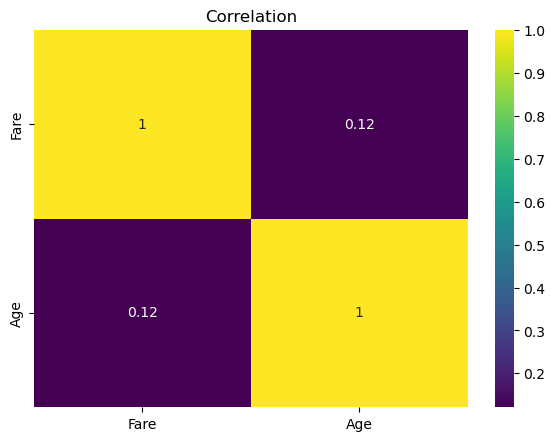

In [646]:
df_corr = df_bis[num_cols].corr()
plt.figure(figsize=(7,5), dpi=100)
sns.heatmap(data=df_corr, annot=True, cmap='viridis')
plt.title("Correlation")

In [254]:
explainer = shap.Explainer(clf, X_train)
shap_values = explainer.shap_values(X_train)
plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
plt.gcf().set_size_inches(7,7)
plt.title("Feature importance - mean(SHAP value)")
plt.xlabel("")
plt.show()

Train on whole train data and export predictions

In [647]:
clf

VotingClassifier(estimators=[('clf1',
                              LogisticRegression(C=1, max_iter=10000,
                                                 random_state=42,
                                                 solver='sag')),
                             ('clf2',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=10,
                                                     max_features=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=6,
                                                     n_estimators=500,
                                                     random_state=42)),
                             ('clf3',
                              GradientBoostingClassifier(learning_rate=0.098,
                                                         loss='deviance',
                                                         max_depth=2,
                                                         min_s...
                                            interaction_constraints=None,
                                            learning_rate=0.14411639396009357,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=4.271886768987027,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=250, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 voting='soft')

In [648]:
clf.fit(X_train, y_train)

The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.


VotingClassifier(estimators=[('clf1',
                              LogisticRegression(C=1, max_iter=10000,
                                                 random_state=42,
                                                 solver='sag')),
                             ('clf2',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=10,
                                                     max_features=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=6,
                                                     n_estimators=500,
                                                     random_state=42)),
                             ('clf3',
                              GradientBoostingClassifier(learning_rate=0.098,
                                                         loss='deviance',
                                                         max_depth=2,
                                                         min_s...
                                            interaction_constraints=None,
                                            learning_rate=0.14411639396009357,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=4.271886768987027,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=250, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 voting='soft')

In [649]:
y_pred = clf.predict(X_test)

In [650]:
output = pd.DataFrame({'PassengerId': y_pred_id, 'Survived': y_pred})
output.to_csv('OUTPUT/submission.csv', index=False)